# Application 1: Fourth Dutch Growth Study

This notebook contains an application illustration for the following paper:

Brachem, J., Wiemann, P. F. V., & Kneib, T. (2024). Bayesian penalized transformation models: Structured additive location-scale regression for arbitrary conditional distributions (No. arXiv:2404.07440). arXiv. https://doi.org/10.48550/arXiv.2404.07440

The data consists of cross-sectional measurements of the body
mass index (BMI) and age of dutch adolescents between the ages 0 and 21 years. The data
originates from the Fourth Dutch Growth Study (Fredriks, van Buuren, Wit, & Verloove-Vanhorick, 2000). 
We use a subset of 7 294 observations
provided in the R package gamlss.data (Stasinopoulos et al., 2021).

References:

- Fredriks, A. M., van Buuren, S., Wit, J. M., & Verloove-Vanhorick, S. P. (2000). Body index measurements in 1996-7 compared with 1980. Archives of Disease in Childhood, 82(2), 107–112. https://doi.org/10.1136/adc.82.2.107
- Stasinopoulos, M., Rigby, B., & De Bastiani, F. (2021). gamlss.data: Data for generalised additive models for location scale and shape [R package] (Version Version 6.0-2) [Computer software]. https://CRAN.R-project.org/package=gamlss.data

## Setup

First, you need to make sure that you are using a suitable environment with all necessary packages available. Please consider the setup instructions in `README.md`.

We need to verify that the correct environment is being used. You can check with this command. The file path should point to the Python executable in your virtual environment.

In [1]:
import sys

print(sys.executable)

/Users/johannesbrachem/Documents/git/ptm-supplement/.venv/bin/python


### Load packages

In [2]:
from pathlib import Path  # for filepath operations
import pandas as pd  # dataframe library
import plotnine as p9  # plotting like with ggplot2
import jax  # a core dependency of liesel and liesel_ptm; provides autodiff and just-in-time-compilation
import jax.numpy as jnp  # jax-compatible numerical operations

import liesel.goose as gs  # liesel's MCMC library, imported here for its diagnostic functions

import liesel_ptm as ptm  # PTM functionality
from liesel_ptm import ps, term  # some specific functions for PTM model setup

In [3]:
# File path handling
wd = Path.cwd()
print(wd)  # print current working directory
if wd.name == "demos":
    demos_dir = wd
    data_dir = wd / ".." / "data"
else:
    demos_dir = wd / "demos"
    data_dir = wd / "data"
print(demos_dir.resolve())  # print demos directory
print(data_dir.resolve())  # print data directory

/Users/johannesbrachem/Documents/git/ptm-supplement/demos
/Users/johannesbrachem/Documents/git/ptm-supplement/demos
/Users/johannesbrachem/Documents/git/ptm-supplement/data


### Load data

In [4]:
data = pd.read_csv(data_dir / "dbbmi.csv")
data.head()

,age,bmi,fold
0,0.03,13.235289,3
1,0.04,12.438775,1
2,0.04,14.541775,7
3,0.04,11.773954,6
4,0.04,15.325614,1


### Pre-process data

In [5]:
# standardize bmi variable
bmi_mean = data["bmi"].mean()
bmi_sd = data["bmi"].std()
data["bmi"] = (data["bmi"] - bmi_mean) / bmi_sd


# standardize age variable
age_mean = data["age"].mean()
age_sd = data["age"].std()
data["age"] = (data["age"] - age_mean) / age_sd

In [6]:
# split data into train and test datasets
fold = 1
train = data[data["fold"] != fold]
test = data[data["fold"] == fold]

## Model

### Initialize transformation model

In [7]:
model = ptm.LocScalePTM.new_ptm(
    # response can be supplied as an array or as a pandas.Series
    response=train["bmi"],
    # The number of transformation function parameters, J-1 in the paper
    # Higher numbers here increase the flexibility of the transformation function
    # default: 20
    nparam=40,
    a=-4.0,  # Left boundary knot, 'a' in the paper (default: -4.0)
    b=7.0,  # Right boundary knot, 'b' in the paper (default: 4.0)
    # Scale 'phi' of the Weibull(0.5, phi) prior for tau^2_\delta
    # default: 0.5
    tau2_scale=0.5,
    # Controls the width of the transition to extrapolation
    # trafo_lambda=0.1 means the width of the transition segment is 0.1*(b-a)
    trafo_lambda=0.1,
    # A switch that can be used to turn on simple linear extrapolation instead
    # of transition to unit slope
    # for linear extrapolation, use "continue_linearly"
    trafo_target_slope="identity",
    # turn off conversion of all float to float32
    to_float32=False,
)

### Add covariate effects

In [8]:
# initialize effect bases
ps_age = ps(train["age"], nbases=20, xname="age")  # P-Spline basis

In [9]:
# effects can be added to the "loc" and "scale" predictors using the "+=" operator
# P-spline with default inverse gamma prior on the variance parameter
model.loc += term.f_ig(ps_age, fname="s")
model.scale += term.f_ig(ps_age, fname="g")

### Build model

In [10]:
# builds the model graph, freezes the model
# No changes to the model structure are possible after this call
model.build()

### Plot model graph

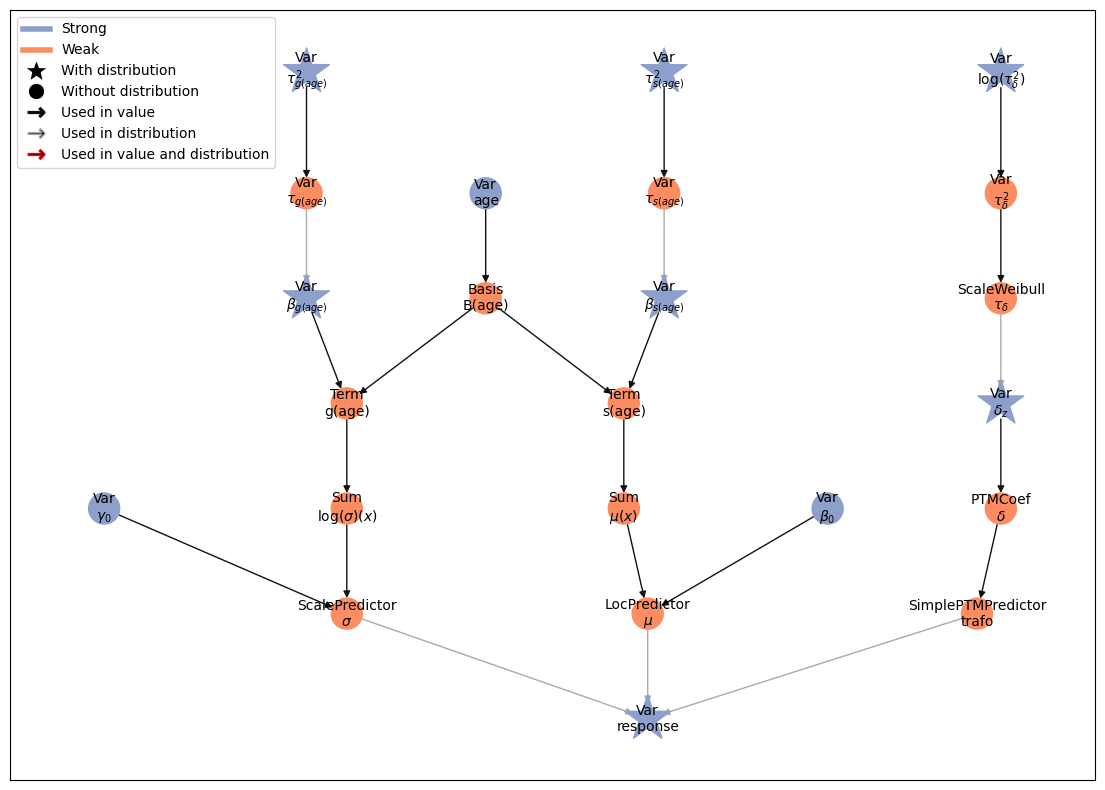

In [11]:
model.graph.plot_vars()

## Run MCMC

We supply relatively low numbers of warmup and posterior samples, and no thinning, here to enable a quick first glance.

In [12]:
results = model.run_mcmc(
    seed=1,
    warmup=500,
    posterior=500,
    thinning_posterior=1,
    num_chains=4,
    warm_start=True,  # whether to apply gradient ascent to find approximations to the posterior modes as initial values
    strategy="iwls-nuts",  # default sampling strategy
    # results can be cached
    # cache_path=demos_dir / "dbbmi.pickle",
)

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 125 transitions, 25 jitted together
100%|██████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 87, 78, 73, 76 / 125 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 2, 1, 1, 2 / 125 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 1, 0, 0, 0 / 125 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 532.47chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 20, 15, 13, 24 / 25 transitions
liesel.goose.engine - INFO - Fini

In [13]:
samples = results.get_posterior_samples()
summary = gs.Summary(results)
errors = summary.error_df().reset_index()

In [14]:
gs.Summary(
    results,
    selected=["$\\tau^2_{s(age)}$", "$\\tau^2_{g(age)}$", "$\\log(\\tau^2_\\delta)$"],
)

Parameter summary:

                                kernel      mean        sd    q_0.05  \
parameter             index                                            
$\log(\tau^2_\delta)$ ()     kernel_00 -3.618323  0.436927 -4.318588   
$\tau^2_{g(age)}$     ()     kernel_02  0.001369  0.000739  0.000612   
$\tau^2_{s(age)}$     ()     kernel_05  0.591452  0.231660  0.311511   

                                q_0.5    q_0.95  sample_size    ess_bulk  \
parameter             index                                                
$\log(\tau^2_\delta)$ ()    -3.640262 -2.874751         2000  397.917732   
$\tau^2_{g(age)}$     ()     0.001210  0.002680         2000  319.654938   
$\tau^2_{s(age)}$     ()     0.542634  1.033068         2000  776.029136   

                                ess_tail      rhat  
parameter             index                         
$\log(\tau^2_\delta)$ ()      875.032489  1.003948  
$\tau^2_{g(age)}$     ()      476.827399  1.013949  
$\tau^2_{s(age)}$     ()     1122.753438  1.004528  

Error summary:

                                                    count relative
kernel    error_code error_msg            phase                   
kernel_00 1          divergent transition warmup       57   0.0285
                                          posterior     0      0.0
          2          maximum tree depth   warmup      544    0.272
                                          posterior     0      0.0
kernel_01 90         nan acceptance prob  warmup        6    0.003
                                          posterior     0      0.0
kernel_04 90         nan acceptance prob  warmup        1   0.0005
                                          posterior     0      0.0

## Inspect diagnostics

### General, aggregate diagnostics

In [15]:
diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail", "kernel"]]
    .groupby("variable", as_index=False)
    .agg(
        kernel=("kernel", "unique"),
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,kernel,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,$\beta_0$,[kernel_06],152.699244,152.699244,412.069244,412.069244,1.047783,1.047783
1,$\beta_{g(age)}$,[kernel_01],239.779461,304.766256,301.839488,458.150385,1.025832,1.017020
2,$\beta_{s(age)}$,[kernel_04],292.413261,313.934720,425.042843,491.000257,1.023222,1.012819
3,$\delta_z$,[kernel_00],521.156298,1673.385714,839.923844,1381.548476,1.008650,1.001645
4,$\gamma_0$,[kernel_03],262.543268,262.543268,445.811210,445.811210,1.020534,1.020534
5,$\log(\tau^2_\delta)$,[kernel_00],397.917732,397.917732,875.032489,875.032489,1.003948,1.003948
6,$\tau^2_{g(age)}$,[kernel_02],319.654938,319.654938,476.827399,476.827399,1.013949,1.013949
7,$\tau^2_{s(age)}$,[kernel_05],776.029136,776.029136,1122.753438,1122.753438,1.004528,1.004528


In [16]:
errors

,kernel,error_code,error_msg,phase,count,relative
0,kernel_00,1,divergent transition,warmup,57,0.0285
1,kernel_00,1,divergent transition,posterior,0,0.0
2,kernel_00,2,maximum tree depth,warmup,544,0.272
3,kernel_00,2,maximum tree depth,posterior,0,0.0
4,kernel_01,90,nan acceptance prob,warmup,6,0.003
5,kernel_01,90,nan acceptance prob,posterior,0,0.0
6,kernel_04,90,nan acceptance prob,warmup,1,0.0005
7,kernel_04,90,nan acceptance prob,posterior,0,0.0


### Transformation function diagnostics

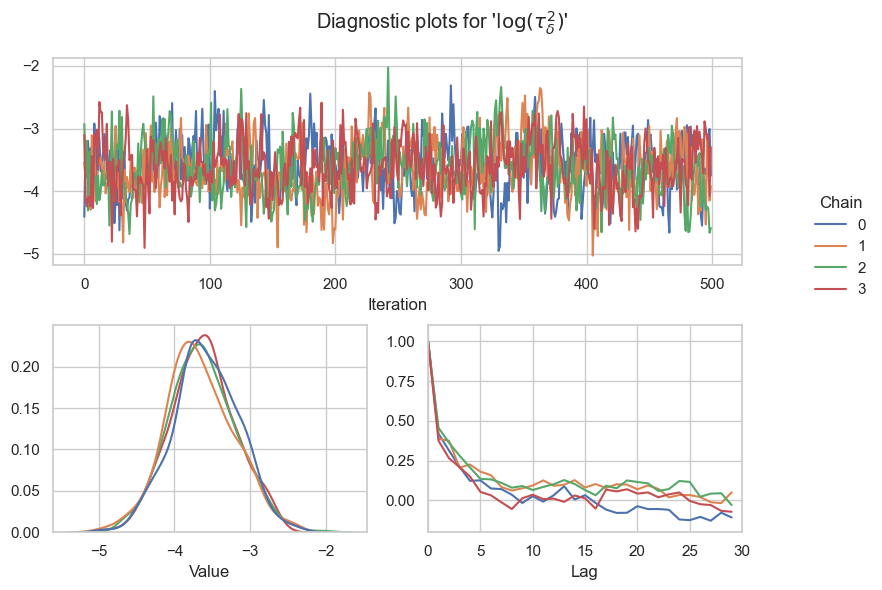

In [17]:
gs.plot_param(results, "$\\log(\\tau^2_\\delta)$")

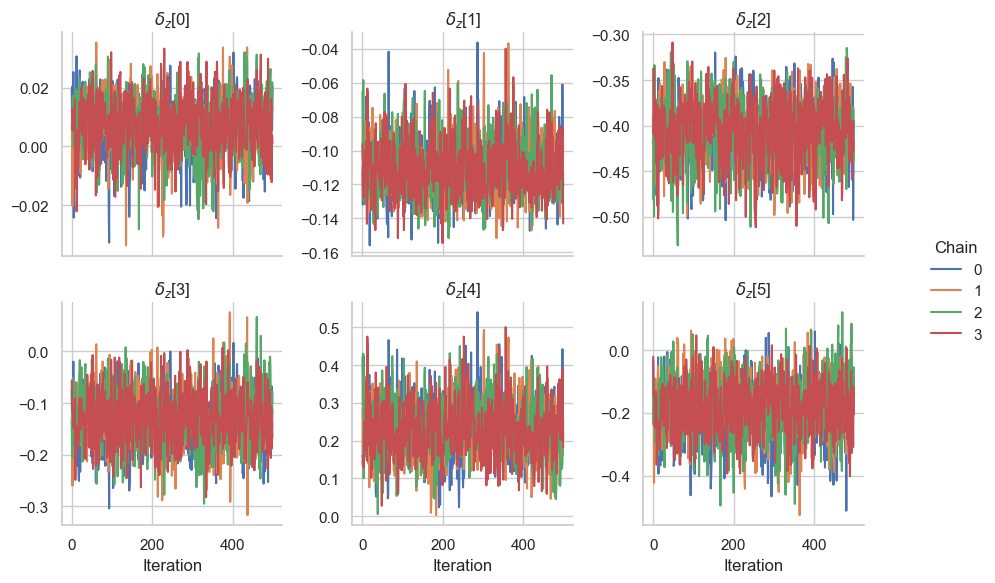

In [18]:
gs.plot_trace(results, "$\\delta_z$", range(6))

## Plot summaries

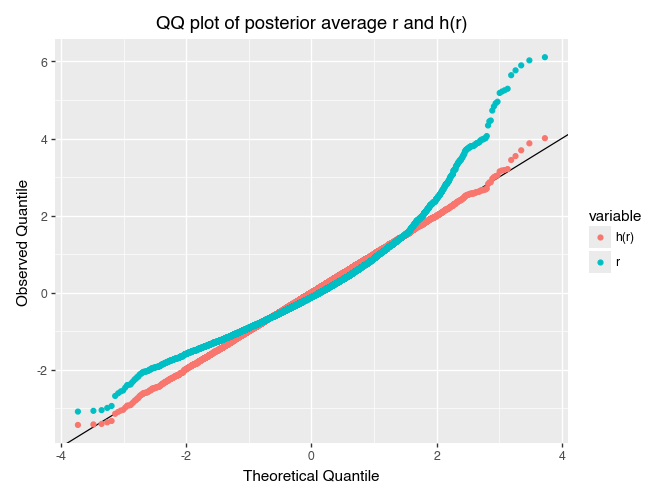

In [19]:
model.plot_qq(samples)

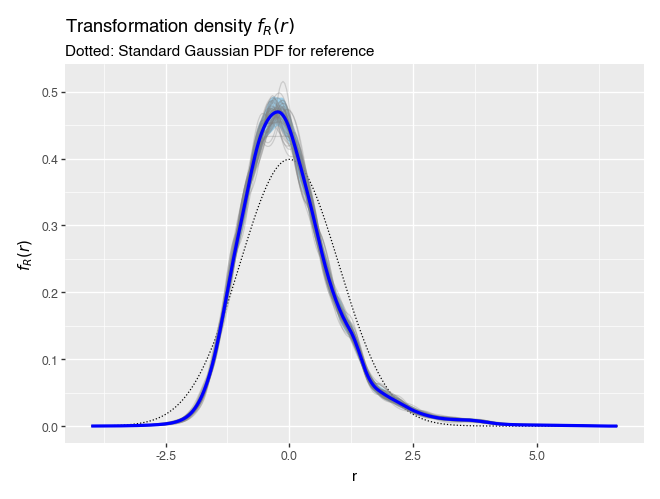

In [20]:
model.plot_r_density(samples)

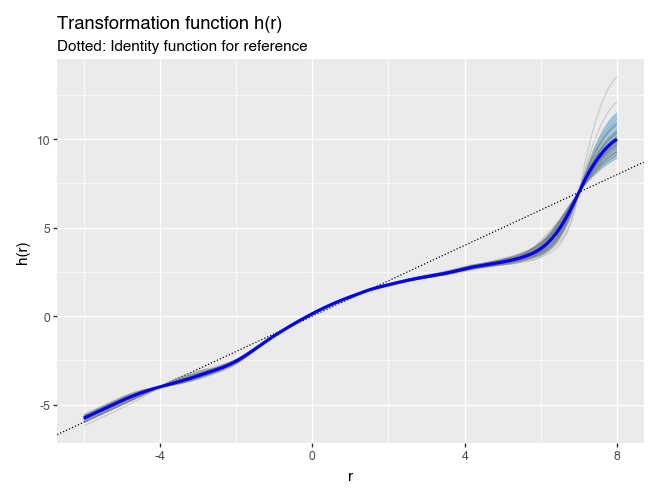

In [21]:
model.plot_trafo(samples, grid=jnp.linspace(-6.0, 8.0, 200))

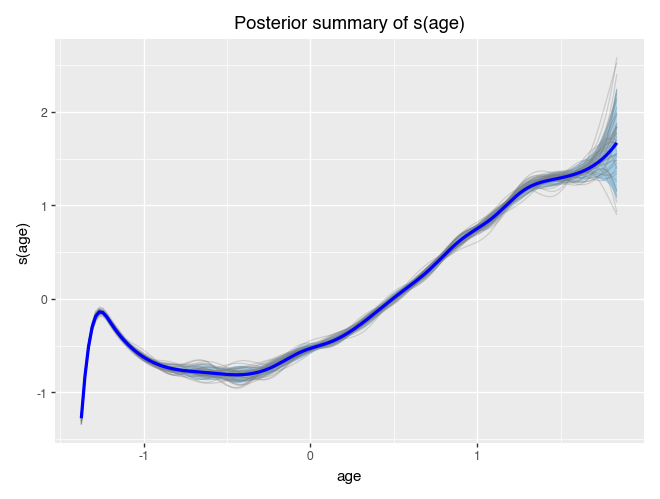

In [22]:
ptm.plot_term(model.loc.terms["s(age)"], samples)

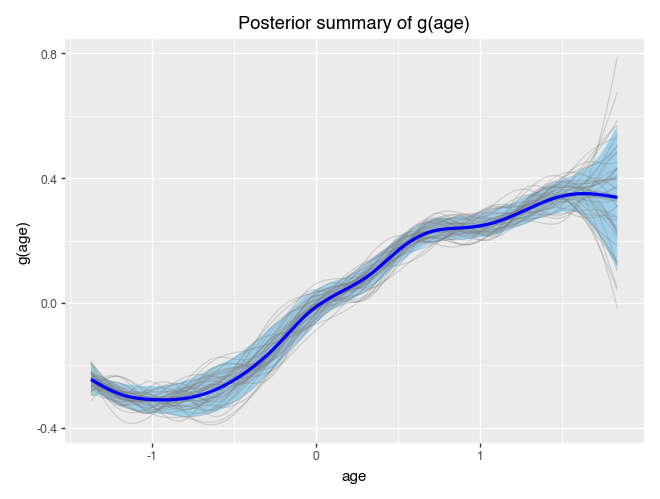

In [23]:
ptm.plot_term(model.scale.terms["g(age)"], samples)

## Predictive distribution

In [24]:
# create new data grid
age_grid = jnp.linspace(data["age"].min(), data["age"].max(), 100)
newdata_grid = {"age": age_grid}

# initialize a tensorflow distribution instance from the samples and the newdata
dist = model.init_dist(samples, newdata=newdata_grid)

# draw predictive samples
pred_samples = dist.sample((1,), seed=jax.random.key(2))

### Evaluate predictive conditional quantiles

In [25]:
probs = jnp.expand_dims(jnp.array([0.01, 0.1, 0.5, 0.9, 0.99]), (1, 2, 3))
pred_quantiles = dist.quantile(probs).mean(axis=(1, 2))

### Plot predictive conditional quantiles

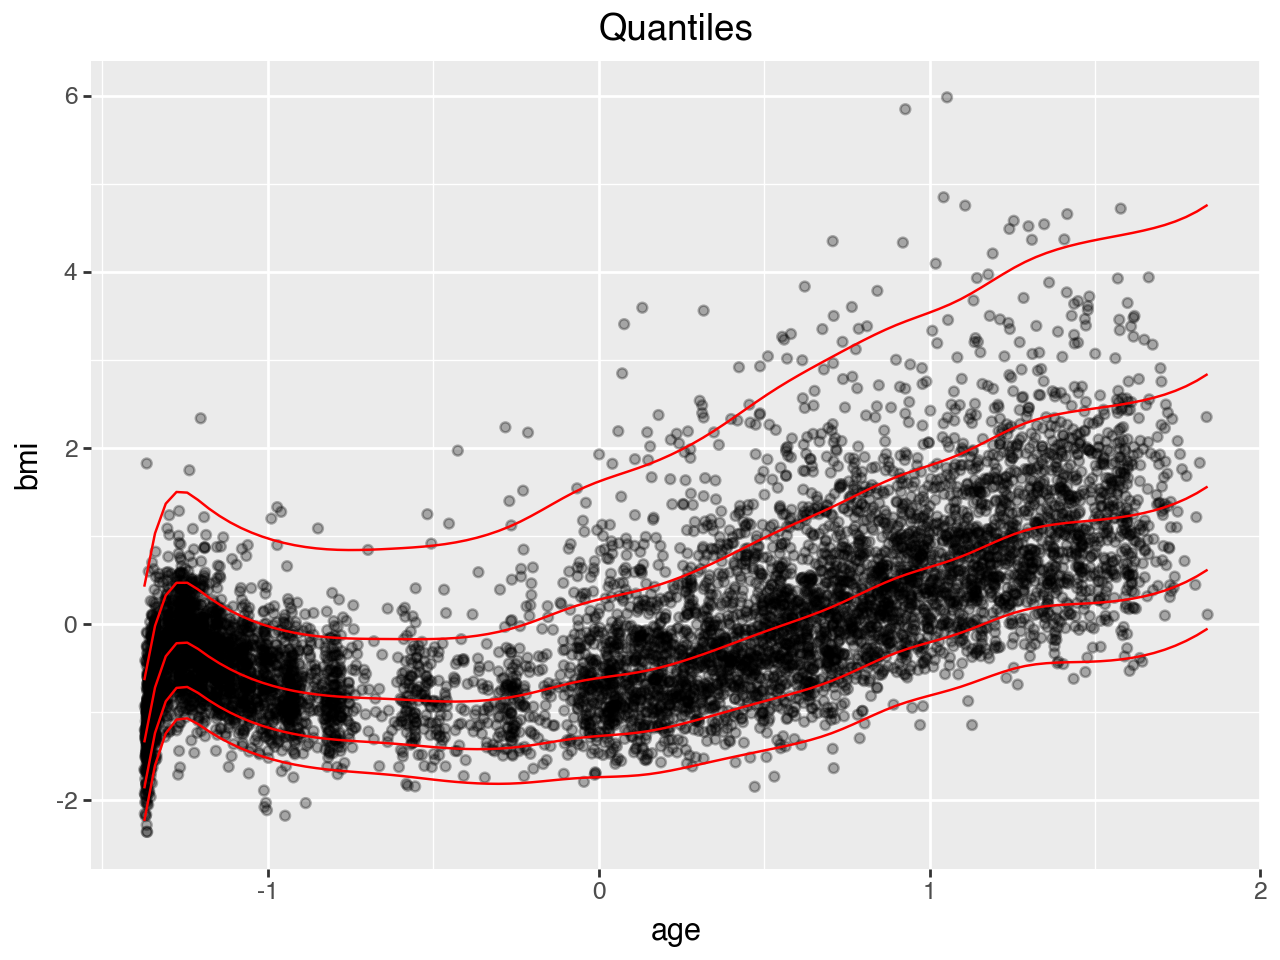

In [26]:
# process quantiles to bring them into a nice format for plotting
quantiles = pd.DataFrame(
    pred_quantiles.T, columns=pd.Index([str(p) for p in probs.squeeze()])
)
quantiles["age_std"] = age_grid
quantiles = quantiles.reset_index(names="n")

quantiles = quantiles.melt(
    id_vars=["n", "age_std"], value_name="bmi_quantile", var_name="prob_level"
)


p = (
    p9.ggplot(quantiles)
    + p9.geom_point(p9.aes("age", "bmi"), data=data, alpha=0.3)
    + p9.geom_line(p9.aes("age_std", "bmi_quantile", group="prob_level"), color="red")
    + p9.labs(title="Quantiles")
)
p.show()

## Performance criteria

### WAIC

In [27]:
meval = ptm.EvaluatePTM(model, samples)
meval.waic()

,waic_lppd,waic_elpd,waic_se,waic_p,waic_deviance,n_warning
0,-6171.601074,-6219.970703,72.217171,48.369846,12439.941406,0


### CRPS via predictive samples

In [28]:
newdata = {}
newdata["age"] = test["age"].to_numpy()

meval = ptm.EvaluatePTM(model, samples)
crps = meval.crps_sample(
    jax.random.key(3),
    predictive_samples_n=1,  # the number of new predictive sample for *each* posterior sample
    newdata=newdata | {"response": test["bmi"].to_numpy()},
    subsamples_n=1000,
)
crps

Array(0.38849014, dtype=float32)

### Log Score

In [29]:
meval.log_score(
    newdata=newdata | {"response": test["bmi"].to_numpy()},
)

Array(660.4541, dtype=float32)